# Ensemble(Boosting)

In [2]:
def get_new_feature_name_df(old_feature_name_df):
        feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
        feature_dup_df = feature_dup_df.reset_index()
        new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
        new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                               if x[1] >0 else x[0] ,  axis=1)
        new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
        return new_feature_name_df

import pandas as pd

def get_human_dataset():
    
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM(Gradient Boosting Machine)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:1f}'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 125.715937


In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate':[0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GricSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

pred = grid_cv.best_estimator_.predict(X_test)
gd_accuracy = accuracy_score(pred, y_test)
print('gbm 정확도: {0:.4f}'.format(gd_accuracy))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

# XGBoost(eXtra Gradient Boost)

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier

In [13]:
print(xgb.__version__)

0.90


In [14]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [15]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [55]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params={
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}

num_rounds=400

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

get_clf_eval(y_test, preds)

[0]	train-logloss:0.609685	eval-logloss:0.61352
[1]	train-logloss:0.540804	eval-logloss:0.547842
[2]	train-logloss:0.483755	eval-logloss:0.494247
[3]	train-logloss:0.434455	eval-logloss:0.447986
[4]	train-logloss:0.390549	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245152	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192183	eval-logloss:0.231556
[13]	train-logloss:0.177917	eval-logloss:0.22005
[14]	train-logloss:0.165221	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-log

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

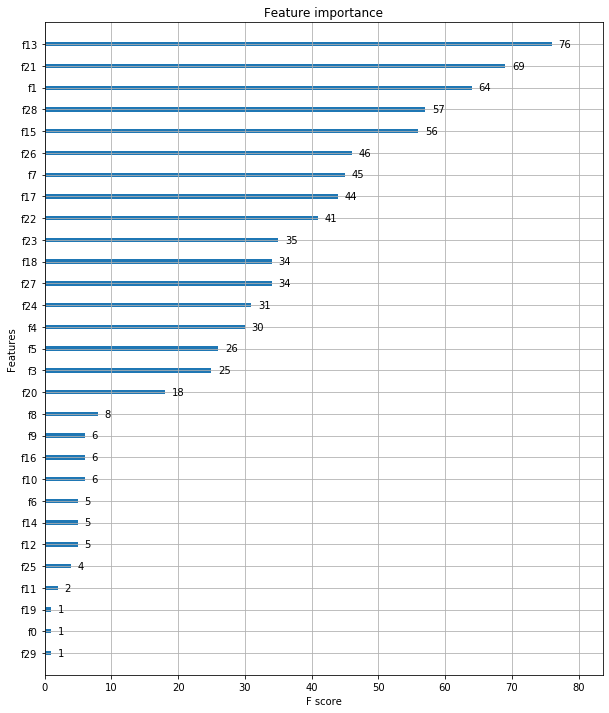

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fit, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# XGBoost(eXtra Gradient Boost)_sklearn

In [38]:
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

In [39]:
def get_clf_eval(y_test,  pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f}, f1: {3:.4f}, AUC:{4:.4f}\n'.format(accuracy, precision, recall, f1, roc_score))

In [40]:
get_clf_eval(y_test, w_preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도:0.9744, 재현율: 0.9870, f1: 0.9806, AUC:0.9665



In [57]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [44]:
get_clf_eval(y_test, ws100_preds)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도:0.9620, 재현율: 0.9870, f1: 0.9744, AUC:0.9530



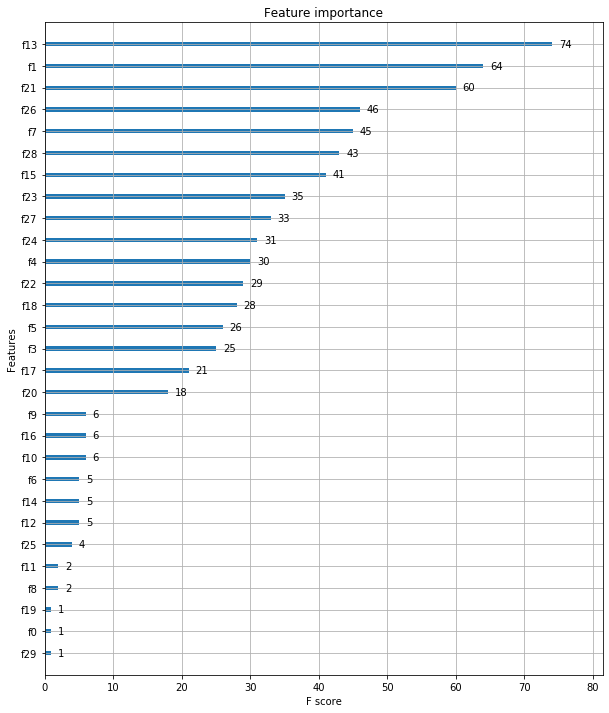

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

# LightGBM

In [54]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

In [48]:
get_clf_eval(y_test, preds)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도:0.9494, 재현율: 0.9740, f1: 0.9615, AUC:0.9330



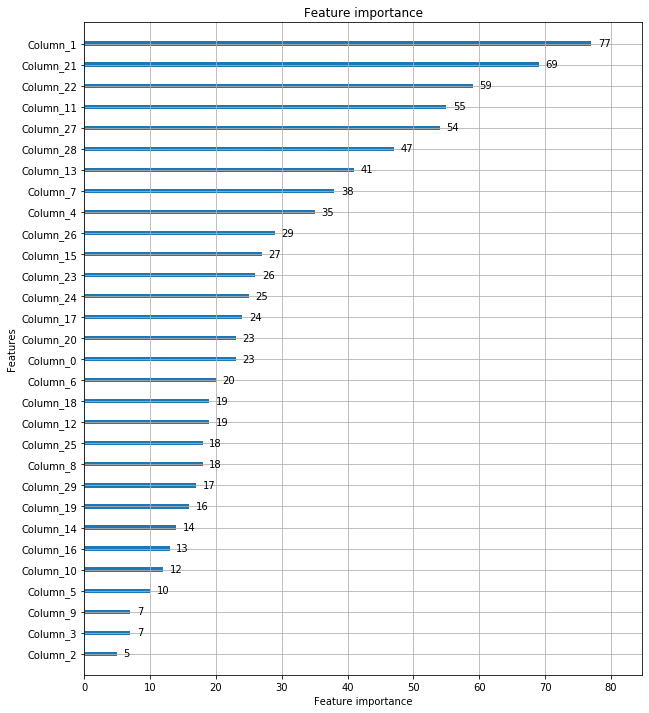

In [50]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)